In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
augmented_df = pd.read_csv('/content/drive/My Drive/Thinkful Data Science/LIDC/augmented_labels.csv')
train_labels = pd.read_csv('/content/drive/My Drive/Thinkful Data Science/LIDC/candidates_train.csv')
test_labels = pd.read_csv('/content/drive/My Drive/Thinkful Data Science/LIDC/candidates_test.csv')
validation_labels = pd.read_csv('/content/drive/My Drive/Thinkful Data Science/LIDC/candidates_validation.csv')

In [0]:
augmented_path = '/content/drive/My Drive/Thinkful Data Science/LIDC/Train augmented/'
train_path = '/content/drive/My Drive/Thinkful Data Science/LIDC/Train/'
test_path = '/content/drive/My Drive/Thinkful Data Science/LIDC/Test/'
validation_path = '/content/drive/My Drive/Thinkful Data Science/LIDC/Validation/'

In [0]:
# Limit our img files to those which contain a nodule (they contain a 'pos' in their filename)
    
train_list = []
for i in os.listdir(train_path):
  if i.startswith('pos'): train_list.append(i)
  
test_list = []
for i in os.listdir(test_path):
  if i.startswith('pos'): test_list.append(i)
    
validation_list = []
for i in os.listdir(validation_path):
  if i.startswith('pos'): validation_list.append(i)

In [0]:
train_df = pd.DataFrame({'x_col': train_list})

test_df = pd.DataFrame({'x_col': test_list})

validation_df = pd.DataFrame({'x_col': validation_list})

In [0]:
# Now we need to structure dataframes for the flow_from_dataframe keras method

for i,img in enumerate(train_df.x_col):
    img_cat = img[0:3]
    img_id = int(''.join([n for n in img if n.isdigit()]))            

    if img_cat == 'pos':
      train_df.loc[i, 'voxel_x'] = train_labels.loc[img_id, 'voxel_x']
      train_df.loc[i, 'voxel_y'] = train_labels.loc[img_id, 'voxel_y']
      train_df.loc[i, 'diameter'] = train_labels.loc[img_id, 'voxel_d2']


for i,img in enumerate(test_df.x_col):
    img_cat = img[0:3]
    img_id = int(''.join([n for n in img if n.isdigit()]))            

    if img_cat == 'pos':
      test_df.loc[i, 'voxel_x'] = test_labels.loc[img_id, 'voxel_x']
      test_df.loc[i, 'voxel_y'] = test_labels.loc[img_id, 'voxel_y']
      test_df.loc[i, 'diameter'] = test_labels.loc[img_id, 'voxel_d2']

for i,img in enumerate(validation_df.x_col):
    img_cat = img[0:3]
    img_id = int(''.join([n for n in img if n.isdigit()]))            

    if img_cat == 'pos':
      validation_df.loc[i, 'voxel_x'] = validation_labels.loc[img_id, 'voxel_x']
      validation_df.loc[i, 'voxel_y'] = validation_labels.loc[img_id, 'voxel_y']
      validation_df.loc[i, 'diameter'] = validation_labels.loc[img_id, 'voxel_d2']


In [10]:
train_batches = ImageDataGenerator(rescale=1/255).flow_from_dataframe(dataframe=augmented_df,
                                                         x_col='img',
                                                         y_col=['x','y','diameter'],
                                                         directory=augmented_path,
                                                         target_size=(65,65),
                                                         class_mode='raw',
                                                         batch_size=32)

test_batches = ImageDataGenerator(rescale=1/255).flow_from_dataframe(dataframe=test_df,
                                                         x_col='x_col',
                                                         y_col=['voxel_x','voxel_y','diameter'],
                                                         directory=test_path,
                                                         target_size=(65,65),
                                                         class_mode='raw',
                                                         batch_size=32)

validation_batches = ImageDataGenerator(rescale=1/255).flow_from_dataframe(dataframe=validation_df,
                                                         x_col='x_col',
                                                         y_col=['voxel_x','voxel_y','diameter'],
                                                         directory=validation_path,
                                                         target_size=(65,65),
                                                         class_mode='raw',
                                                         batch_size=32)

Found 3400 validated image filenames.
Found 102 validated image filenames.
Found 225 validated image filenames.


In [0]:
imgs, labels = next(train_batches)

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


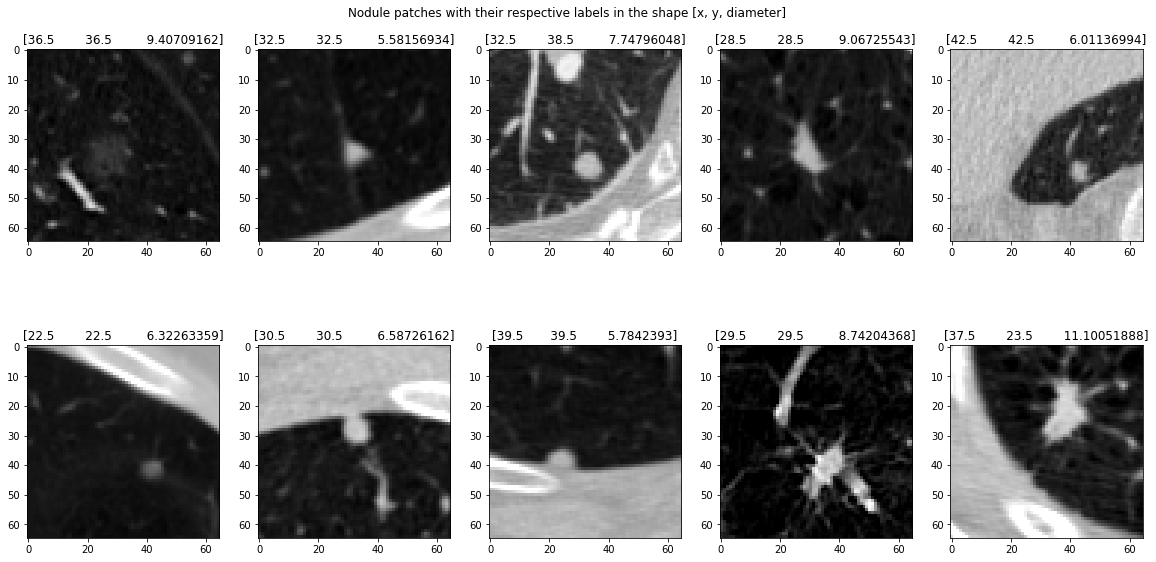

In [0]:
plt.figure(figsize=(20,10))
plt.suptitle('Nodule patches with their respective labels in the shape [x, y, diameter]', y=0.9)

for i, img in enumerate(imgs[0:10]):
  plt.subplot(2,5,i+1)
  plt.imshow(img)
  plt.title(labels[i])
  
plt.show()

In [0]:
NAME = 'localization_DA'

model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(65,65,3)),
        MaxPooling2D(pool_size=(2,2)),
    
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
    
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
    
        Flatten(),
        Dense(64, activation='relu'),
        Dense(3, activation='linear')
    ])

In [11]:
NAME = 'localization_0.2_dropout_DA'

model = load_model('/content/drive/My Drive/Thinkful Data Science/LIDC/logs/models/localization_0.2_dropout.hdf5')






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.











In [0]:
model.compile(Adam(lr=.0001), loss='mean_squared_error', metrics=['accuracy'])

log_dir=f"/content/drive/My Drive/Thinkful Data Science/LIDC/logs/fit/{NAME}"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)

model_dir=f"/content/drive/My Drive/Thinkful Data Science/LIDC/logs/models/{NAME}.hdf5"
model_ckpt = keras.callbacks.ModelCheckpoint(filepath=model_dir, 
                                          monitor='val_loss', 
                                          verbose=0, 
                                          save_best_only=True, 
                                          save_weights_only=False, 
                                          mode='auto', 
                                          period=1)

In [13]:
model.fit_generator(train_batches, 
                    steps_per_epoch=106,
                    validation_data=validation_batches, 
                    validation_steps=7, epochs=100, 
                    verbose=2,
                    initial_epoch=0,
                   callbacks=[tensorboard_callback, model_ckpt])

Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.307396). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.220561). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110337). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - 1717s - loss: 35.4764 - acc: 0.7379 - val_loss: 16.6237 - val_acc: 0.8304
Epoch 2/100
 - 28s - loss: 31.5519 - acc: 0.7503 - val_loss: 16.0059 - val_acc: 0.8497
Epoch 3/100
 - 11s - loss: 31.3248 - acc: 0.7394 - val_loss: 15.8573 - val_acc: 0.8238
Epoch 4/100
 - 11s - loss: 31.0347 - acc: 0.7527 - val_loss: 17.0520 - val_acc: 0.8446
Epoch 5/100
 - 11s - loss: 30.6818 - acc: 0.7474 - val_loss: 14.5165 - val_acc: 0.8705
Epoch 6/100
 - 11s - loss: 30.4030 - acc: 0.7603 - val_loss: 15.7699 - val_acc: 0.8446
Epoch 7/100
 - 11s - loss: 30.2064 - acc: 0.7518 - val_loss: 16.5228 - val_acc: 0.8601
Epoch 8/100
 - 11s - loss: 29.6319 - acc: 0.7538 - val_loss: 16.0953 - val_acc: 0.8705
Epoch 9/100
 - 11s - loss: 29.0866 - acc: 0.7665 - val_loss: 17.3418 - val_acc: 0.8438
Epoch 10/100
 - 11s - loss: 29.9954 - acc: 0.7574 - val_loss: 16.4545 - val_acc: 0.8601
Epoch 11/100
 - 11s - loss: 29.4508 - acc: 0.7736 - val_loss: 14.9962 - val_acc: 0.8860
Epoch 12/100
 - 11s - loss: 29.3892 - acc: 0.7609 -